<IPython.core.display.Javascript object>


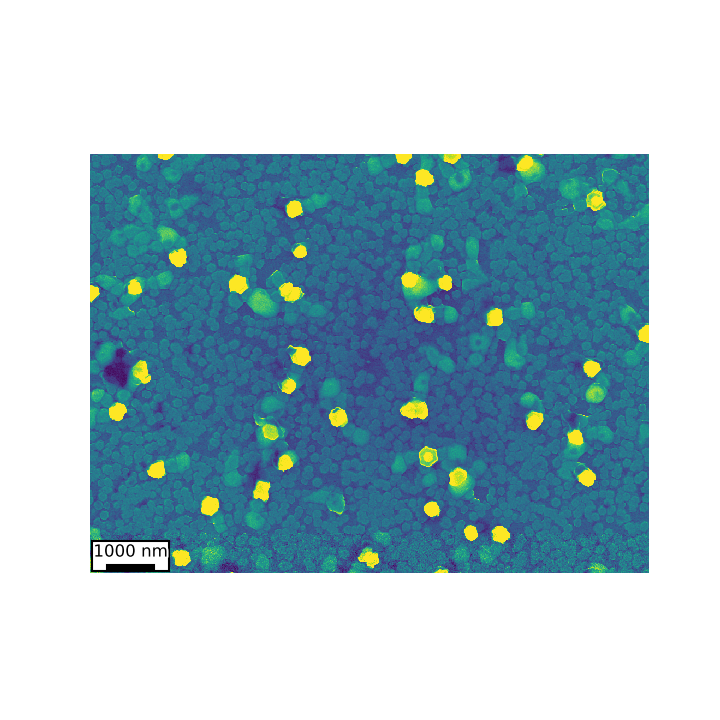

In [35]:
import h5py as h5
import hyperspy.api as hs
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patheffects as patheffects

# odemis h5 to hspy function:
from odemishspy import odemis_to_hyperspy

# switch off the too many warnings...
import warnings
warnings.filterwarnings('ignore')

s=hs.load('sampledata/SEMZeissTest.tif')
#s = odemis_to_hyperspy('sampledata/cltest2.h5',specbin=1)
#s.plot()
#s.original_metadata

fig, ax = plt.subplots(figsize=plt.figaspect(1))

cax = ax.imshow(s.data, extent=s.axes_manager.signal_extent, cmap='viridis')
cax.set_clim(2000, 31000)
ax.set_axis_off()



fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(
        transform=ax.transData, size=1000, label='1000 nm',
        loc=3, frameon=True,
        color='black', size_vertical=100,
        label_top=True,
        fontproperties=fontprops)
scalebar.txt_label._text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white', capstyle="round")])
scalebar.txt_label._text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white', capstyle="round")])
ax.add_artist(scalebar)

plt.show()


In [9]:
import h5py as h5
import hyperspy.api as hs
import numpy as np

# switch of the too many warnings...
import warnings
warnings.filterwarnings('ignore')

def odemis_to_hyperspy(filename='sampledata/cltest.h5',specbin=1) :
    """
    odemis_to_hyperspy(filename='cltest.h5',specbin=1)
    open h5 files from Delmic Odemis and convert them to a hyperspy object
    reads in the spectral data (only) from hyperspectral maps and panchromatic
    CL maps using the PM
    1.arg: filename
    2.arg: binning for hyperspectral maps

    """

    f=h5.File(filename,'r')
    shome = 'Acquisition2//ImageData/'
    x = f[shome + 'Image']
    cdesc =f['Acquisition2/PhysicalData/ChannelDescription'].value[0].decode('utf-8')
    #print(cdesc)

    cltype = None
    if 'Spectrum' in cdesc :
        cltype = 'spectrum'
    elif 'CL intensity' in cdesc:
        cltype = 'panchrom'

    print('<' + filename + '> original shape :' ,x.shape)
    # strip unused dimensions and transpose/ reverse index order
    xx=x[:,0,0,:,:].transpose((2,1,0))

    if cltype == 'spectrum' :
        #make a linear fit to the wavelength axis
        w  = f[shome + 'DimensionScaleC'].value *1e9
        wx = np.linspace(w.min(),w.max(),w.size)
        for i in np.arange(xx.shape[0]) :
            for k in np.arange(xx.shape[1]) :
                xx[i,k,:] = np.interp(wx,w,xx[i,k,:])
                #i = i+1
                #pass
        wslope = wx[1]-wx[0]
        woffset = wx.min()
        #wx = np.arange(w.size)
        #wslope,woffset=np.polyfit(wx,w,1)
        s = hs.signals.Signal1D(xx)

    elif cltype == 'panchrom' :
        s = hs.signals.Signal2D(xx)
    else :
        print('unknown type')

    print('hyperspy shape :' ,s.data.shape)


    s.metadata.General.title = 'Odemis: ' + cdesc
    s.metadata.General.original_filename = filename
    s.metadata.General.notes = cltype
    s.axes_manager[0].name = 'pos x'
    s.axes_manager[0].scale = f[shome + 'DimensionScaleX'].value * 1e6
    s.axes_manager[0].offset = f[shome + 'XOffset'].value * 1e6
    s.axes_manager[0].units = 'um'

    print(f[shome + 'XOffset'].value)

    s.axes_manager[1].name = 'pos y'
    s.axes_manager[1].scale = f[shome + 'DimensionScaleX'].value * 1e6
    s.axes_manager[1].offset = f[shome + 'YOffset'].value * 1e6
    s.axes_manager[1].units = 'um'

    if cltype == 'spectrum' :
        s.axes_manager[2].name = 'wavelength'
        s.axes_manager[2].units = 'nm'
        s.axes_manager[2].offset = woffset
        s.axes_manager[2].scale = wslope
        s.metadata.signal_type = 'CL'

    f.close()
    if (specbin > 1) and (cltype == 'spectrum'):
        return( s.rebin(scale=[1,1,specbin]) )
    else :
        return( s )
    #end odemis_to_hyperspy
    #######################



s=odemis_to_hyperspy('sampledata/cltest2.h5')
s.axes_manager.gui()

<sampledata/cltest2.h5> original shape : (2560, 1, 1, 109, 91)
hyperspy shape : (91, 109, 2560)
0.06218673354304633


HBox(children=(Accordion(children=(VBox(children=(HBox(children=(Label(value='Name'), Text(value='pos x')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Size', layout=Layout(width='auto')), IntText(value=109, disabled=True)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Index in array', layout=Layout(width='auto')), IntText(value=1, disabled=True)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Index', layout=Layout(width='auto')), IntSlider(value=0, max=108)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Value', layout=Layout(width='auto')), FloatSlider(value=62186.73354304633, max=62188.89354304633, min=62186.73354304633, step=0.020000000000000007)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Units', layout=Layout(width='auto')), Text(value='um')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Scale', layout=Layout(width='auto')), FloatText(value=0.020000000000000007)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Offset', layout=Layout(width='auto')), FloatText(value=62186.73354304633)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')))), VBox(children=(HBox(children=(Label(value='Name'), Text(value='pos y')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Size', layout=Layout(width='auto')), IntText(value=91, disabled=True)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Index in array', layout=Layout(width='auto')), IntText(value=0, disabled=True)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Index', layout=Layout(width='auto')), IntSlider(value=0, max=90)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Value', layout=Layout(width='auto')), FloatSlider(value=67757.53069193881, max=67759.33069193881, min=67757.53069193881, step=0.020000000000000007)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Units', layout=Layout(width='auto')), Text(value='um')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Scale', layout=Layout(width='auto')), FloatText(value=0.020000000000000007)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Offset', layout=Layout(width='auto')), FloatText(value=67757.53069193881)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between'))))), _titles={'0': 'Axis 0', '1': 'Axis 1'}), Accordion(children=(VBox(children=(HBox(children=(Label(value='Name'), Text(value='wavelength')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Size', layout=Layout(width='auto')), IntText(value=2560, disabled=True)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Index in array', layout=Layout(width='auto')), IntText(value=2, disabled=True)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Units', layout=Layout(width='auto')), Text(value='nm')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), HBox(children=(Label(value='Scale', layout=Layout(width='auto')), FloatText(value=0.10482958621838634)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between'